## Authorship attribution with Burrows' Delta

In this exercise we'll put together some of the things we've learned about textual analysis to see whether we can distinguish two authors of mystery and suspense around the turn of the 20th century. 

On one hand, we have a set of short stories by [E. Nesbit](https://en.wikipedia.org/wiki/E._Nesbit). She's known mostly as a children's writer, but she also wrote horror and mystery stories, and I've selected some of those (from her collection *Grim Tales*). For comparison, I've chosen a selection of short stories by Arthur Conan Doyle. 

### Preliminaries

#### Create a local copy of the corpus
Since we're running this in Google Colab, we have to download the corpus separately from the git repo.

In [2]:
# Colab only
!rm -rf clas-3801 corpus
!git clone https://github.com/cwf2/clas-3801-fa23
!mv clas-3801-fa23/Week_05/corpus .
!rm -rf clas-3801-fa23

Cloning into 'clas-3801-fa23'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 2), reused 30 (delta 1), pack-reused 0
Receiving objects: 100% (31/31), 345.79 KiB | 1.16 MiB/s, done.
Resolving deltas: 100% (2/2), done.


#### import statements

In [3]:
import os
import requests
import pandas as pd
import spacy
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

#### Load the language model

We're going to be using SpaCy for tokenization and lemmatization in this case, rather than the builtin Python string manipulation methods. The first step is to load an English language model.

In [5]:
nlp = spacy.load('en_core_web_sm')

### Step 1: Read the files

We're going to read the files from a local directory, parse them, and organize the tokenized text into a single table with Pandas.

#### First, scan the directory for available texts

In [7]:
# read all the filenames from the corpus directory
dir_texts = 'corpus'
files = [f for f in os.listdir(dir_texts) if not f.startswith('.')]

#### Loop over all the files and parse them

In this `for` loop we:
- read the text of the file into a string
- process the string with SpaCy to produce a Doc object
- extract just the tokens from the doc
- store them along with title and author in a dictionary
- append the dictionary to a growing list of dictionaries

In [11]:
# start with an empty list
corpus = []

# loop over files
for i, filename in enumerate(files):
    # extract the author and title from the filename
    author, title = filename[:-4].split('_', 1)

    # add back the directory name to get a path to the file
    path = os.path.join('corpus', filename)

    # read the file
    print(f'[{i+1}/{len(files)}] {path}', end='...')
    
    with open(path) as f:
        fulltext = f.read()

        # parse with SpaCy pipeline
        doc = nlp(fulltext)
        # extract just the tokens
        tokens = [tok for tok in doc]
        print(len(doc), 'tokens')

        # add a new record to the list
        corpus.append(dict(
            author = author,
            title = title,
            token = tokens,
        ))

[1/18] corpus/nesbit_from_the_dead.txt...7004 tokens
[2/18] corpus/doyle_the_man_with_the_twisted_lip.txt...12040 tokens
[3/18] corpus/doyle_the_adventure_of_the_blue_carbuncle.txt...10482 tokens
[4/18] corpus/nesbit_the_ebony_frame.txt...9501 tokens
[5/18] corpus/nesbit_man-size_in_marble.txt...7041 tokens
[6/18] corpus/doyle_the_adventure_of_the_speckled_band.txt...12756 tokens
[7/18] corpus/doyle_the_adventure_of_the_noble_bachelor.txt...10728 tokens
[8/18] corpus/nesbit_uncle_abraham’s_romance.txt...1693 tokens
[9/18] corpus/doyle_a_scandal_in_bohemia.txt...11406 tokens
[10/18] corpus/doyle_a_case_of_identity.txt...9106 tokens
[11/18] corpus/nesbit_the_mass_for_the_dead.txt...4508 tokens
[12/18] corpus/doyle_the_five_orange_pips.txt...9570 tokens
[13/18] corpus/doyle_the_red-headed_league.txt...12054 tokens
[14/18] corpus/nesbit_the_mystery_of_the_semi-detached.txt...1613 tokens
[15/18] corpus/doyle_the_adventure_of_the_copper_beeches.txt...12861 tokens
[16/18] corpus/doyle_the_bos

#### Convert our data to a Pandas DataFrame

Here we turn our list of dictionaries into a DataFrame to make it easer to see.

In [12]:
# convert list of dictionaries to a Data Frame
corpus = pd.DataFrame(corpus)
display(corpus)

,author,title,token
0,nesbit,from_the_dead,"[I., \n\n, "", But, true, or, not, true, ,, you..."
1,doyle,the_man_with_the_twisted_lip,"[Isa, Whitney, ,, brother, of, the, late, Elia..."
2,doyle,the_adventure_of_the_blue_carbuncle,"[I, had, called, upon, my, friend, Sherlock, H..."
3,nesbit,the_ebony_frame,"[To, be, rich, is, a, luxurious, sensation, --..."
4,nesbit,man-size_in_marble,"[Although, every, word, of, this, story, is, a..."
5,doyle,the_adventure_of_the_speckled_band,"[On, glancing, over, my, notes, of, the, seven..."
6,doyle,the_adventure_of_the_noble_bachelor,"[The, Lord, St., Simon, marriage, ,, and, its,..."
7,nesbit,uncle_abraham’s_romance,"["", No, ,, my, dear, ,, "", my, Uncle, Abraham,..."
8,doyle,a_scandal_in_bohemia,"[I., \n\n, To, Sherlock, Holmes, she, is, alwa..."
9,doyle,a_case_of_identity,"[“, My, dear, fellow, ,, ”, said, Sherlock, Ho..."


#### Break out the tokens into separate rows

Right now, our table has one row per work, and the `token` column contains a list for each row. Next we're going to use the [`explode()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html) method to break out the tokens into separate rows. For example, each token in "From the Dead" will now have its own row, with the `author` and `title` values copied from the original row.

In [19]:
# break out the `token` column
tokens = pd.DataFrame(corpus).explode('token', ignore_index=True)
display(tokens)

,author,title,token
0,nesbit,from_the_dead,I.
1,nesbit,from_the_dead,\n\n
2,nesbit,from_the_dead,""""
3,nesbit,from_the_dead,But
4,nesbit,from_the_dead,true
...,...,...,...
168113,doyle,the_adventure_of_the_beryl_coronet,sufficient
168114,doyle,the_adventure_of_the_beryl_coronet,\n
168115,doyle,the_adventure_of_the_beryl_coronet,punishment
168116,doyle,the_adventure_of_the_beryl_coronet,.


### Step 2: Feature Extraction

Right now, the `token` column is displaying in Jupyter as if it just held the text of the tokens, but really this column contains SpaCy Token objects, each containing a bunch of complex linguistic data. I want to extract three attributes from each token that I can use as features:
- `text`: a string representing how it looked in the original story
- `lemma_`: a string representing its **lemma** or dictionary headword
- `pos_`: a string representing its **part of speech**

Note the underscores following `lemma_` and `pos_`. If you don't add the underscore, then SpaCy will give you a numeric code for these features instead of a string.

I'm assigning the new features to columns called `text`, `lemma` and `pos`.

In [20]:
# add `text` column
tokens['text'] = [tok.text for tok in tokens['token']]

# add `lemma` column
tokens['lemma'] = [tok.lemma_ for tok in tokens['token']]

# add `pos` column
tokens['pos'] = [tok.pos_ for tok in tokens['token']]

display(tokens)

,author,title,token,text,lemma,pos
0,nesbit,from_the_dead,I.,I.,i.,NOUN
1,nesbit,from_the_dead,\n\n,\n\n,\n\n,SPACE
2,nesbit,from_the_dead,"""","""","""",PUNCT
3,nesbit,from_the_dead,But,But,but,CCONJ
4,nesbit,from_the_dead,true,true,true,ADJ
...,...,...,...,...,...,...
168113,doyle,the_adventure_of_the_beryl_coronet,sufficient,sufficient,sufficient,ADJ
168114,doyle,the_adventure_of_the_beryl_coronet,\n,\n,\n,SPACE
168115,doyle,the_adventure_of_the_beryl_coronet,punishment,punishment,punishment,NOUN
168116,doyle,the_adventure_of_the_beryl_coronet,.,.,.,PUNCT


#### Tidy up the data a little

The table now has one row for every token in the corpus, with columns for the text, lemma, and part of speech. But it's clear that some of the things SpaCy considers tokens aren't words, like punctuation marks, numerals, and some kinds of whitespace. 

Here I'm going to omit rows according to certain criteria.

In [23]:
# keep only rows where part of speech is not punctuation
tokens = tokens.loc[tokens['pos'] != 'PUNCT']

# keep only rows where part of speech is not space
tokens = tokens.loc[tokens['pos'] != 'SPACE']

# keep only rows where part of speech is not proper noun (i.e. personal names)
tokens = tokens.loc[tokens['pos'] != 'PROPN']

# keep only rows where the token text has at least one letter in it
tokens = tokens.loc[tokens['text'].str.contains(r'[A-Za-z]')]

display(tokens)

,author,title,token,text,lemma,pos
0,nesbit,from_the_dead,I.,I.,i.,NOUN
3,nesbit,from_the_dead,But,But,but,CCONJ
4,nesbit,from_the_dead,true,true,true,ADJ
5,nesbit,from_the_dead,or,or,or,CCONJ
6,nesbit,from_the_dead,not,not,not,PART
...,...,...,...,...,...,...
168110,doyle,the_adventure_of_the_beryl_coronet,a,a,a,DET
168111,doyle,the_adventure_of_the_beryl_coronet,more,more,more,ADJ
168112,doyle,the_adventure_of_the_beryl_coronet,than,than,than,ADP
168113,doyle,the_adventure_of_the_beryl_coronet,sufficient,sufficient,sufficient,ADJ


### Step 3: Feature vectors for each work

Now that we have all the features broken out, we can calculate some statistics that will allow us to characterize each work as a bundle of features.

#### Part of speech features

Let's start by looking at how each text uses different parts of speech. We'll use the `crosstab()` function to get a count for each unique value in `pos`, for each unique combination of `author` and `title`:

In [26]:
pos_count = pd.crosstab([tokens['author'], tokens['title']], tokens['pos'])
display(pos_count)

pos                                           ADJ   ADP  ADV  AUX  CCONJ  \
author title                                                               
doyle  a_case_of_identity                     485   740  447  530    290   
       a_scandal_in_bohemia                   505   985  481  655    334   
       the_adventure_of_the_beryl_coronet     559  1018  610  841    329   
       the_adventure_of_the_blue_carbuncle    464   912  435  600    269   
       the_adventure_of_the_copper_beeches    706  1105  610  817    375   
       the_adventure_of_the_engineer’s_thumb  538   939  533  647    324   
       the_adventure_of_the_noble_bachelor    522   872  538  637    293   
       the_adventure_of_the_speckled_band     636  1155  549  710    355   
       the_boscombe_valley_mystery            617  1054  551  811    367   
       the_five_orange_pips                   405   901  350  565    292   
       the_man_with_the_twisted_lip           566  1090  531  703    345   
       the_red-headed_league                  621  1004  556  678    365   
nesbit from_the_dead                          311   482  328  382    229   
       man-size_in_marble                     408   580  358  409    276   
       the_ebony_frame                        434   796  383  475    295   
       the_mass_for_the_dead                  222   331  168  265    177   
       the_mystery_of_the_semi-detached        97   137   71   89     83   
       uncle_abraham’s_romance                 83   112   91   88     66   

pos                                            DET  INTJ  NOUN  NUM  PART  \
author title                                                                
doyle  a_case_of_identity                      639    33  1064   50   198   
       a_scandal_in_bohemia                    809    21  1360   81   230   
       the_adventure_of_the_beryl_coronet      842    32  1472   74   246   
       the_adventure_of_the_blue_carbuncle     832    54  1328   62   158   
       the_adventure_of_the_copper_beeches     901    50  1521   82   256   
       the_adventure_of_the_engineer’s_thumb   817    33  1346   82   177   
       the_adventure_of_the_noble_bachelor     784    51  1217   50   201   
       the_adventure_of_the_speckled_band     1035    40  1754   74   203   
       the_boscombe_valley_mystery             927    38  1516   70   233   
       the_five_orange_pips                    783    21  1260   73   149   
       the_man_with_the_twisted_lip            937    39  1603   69   202   
       the_red-headed_league                   872    38  1456   78   228   
nesbit from_the_dead                           397    40   753   33   165   
       man-size_in_marble                      522    17   935   34   140   
       the_ebony_frame                         680    38  1309   47   191   
       the_mass_for_the_dead                   264    17   562   17   136   
       the_mystery_of_the_semi-detached        146     1   214    5    40   
       uncle_abraham’s_romance                 112     7   204    7    35   

pos                                           PRON  SCONJ  VERB  X  
author title                                                        
doyle  a_case_of_identity                     1108    275   899  2  
       a_scandal_in_bohemia                   1412    269  1139  0  
       the_adventure_of_the_beryl_coronet     1805    383  1341  0  
       the_adventure_of_the_blue_carbuncle    1218    252  1019  0  
       the_adventure_of_the_copper_beeches    1645    339  1259  0  
       the_adventure_of_the_engineer’s_thumb  1371    291  1113  3  
       the_adventure_of_the_noble_bachelor    1260    290  1039  3  
       the_adventure_of_the_speckled_band     1537    318  1277  0  
       the_boscombe_valley_mystery            1567    379  1229  0  
       the_five_orange_pips                   1117    264   914  0  
       the_man_with_the_twisted_lip           1388    321  1193  0  
       the_red-headed_league             

#### Normalization

This is already interesting, but of course, some of the texts are longer than others, so the raw counts might not be the most helpful way to look at part of speech use. Instead, we'll calculate how many times each part of speech is used per 1000 tokens.

By passing the `normalize` argument to `crosstab()` we can ask Pandas to divide each value by the total for its row (i.e., normalize by *index*). Since each row is one work, this tells us the fraction of all tokens in the work represented by each column. Then we multiply by 1000 just to make the numbers easier to read. We've now converted counts to frequencies.

In [27]:
pos_freq = pd.crosstab([tokens['author'], tokens['title']], tokens['pos'], normalize="index")*1000
display(pos_freq)

pos                                                 ADJ         ADP  \
author title                                                          
doyle  a_case_of_identity                     71.745562  109.467456   
       a_scandal_in_bohemia                   60.982973  118.946987   
       the_adventure_of_the_beryl_coronet     58.521776  106.574539   
       the_adventure_of_the_blue_carbuncle    61.028541  119.952650   
       the_adventure_of_the_copper_beeches    73.039520  114.318229   
       the_adventure_of_the_engineer’s_thumb  65.497930  114.317020   
       the_adventure_of_the_noble_bachelor    67.294057  112.414593   
       the_adventure_of_the_speckled_band     65.954578  119.776003   
       the_boscombe_valley_mystery            65.925847  112.618870   
       the_five_orange_pips                   57.090499  127.008740   
       the_man_with_the_twisted_lip           62.979860  121.286302   
       the_red-headed_league                  70.408163  113.832200   
nesbit from_the_dead                          59.532925   92.266462   
       man-size_in_marble                     75.892857  107.886905   
       the_ebony_frame                        60.801345  111.515831   
       the_mass_for_the_dead                  65.217391   97.238543   
       the_mystery_of_the_semi-detached       76.679842  108.300395   
       uncle_abraham’s_romance                67.315491   90.835361   

pos                                                 ADV        AUX      CCONJ  \
author title                                                                    
doyle  a_case_of_identity                     66.124260  78.402367  42.899408   
       a_scandal_in_bohemia                   58.084772  79.096727  40.333293   
       the_adventure_of_the_beryl_coronet     63.860972  88.044389  34.443049   
       the_adventure_of_the_blue_carbuncle    57.214258  78.916217  35.380771   
       the_adventure_of_the_copper_beeches    63.107801  84.523071  38.795779   
       the_adventure_of_the_engineer’s_thumb  64.889214  78.767957  39.444850   
       the_adventure_of_the_noble_bachelor    69.356710  82.119376  37.772335   
       the_adventure_of_the_speckled_band     56.932490  73.628539  36.814269   
       the_boscombe_valley_mystery            58.873811  86.654557  39.213591   
       the_five_orange_pips                   49.337468  79.644770  41.161545   
       the_man_with_the_twisted_lip           59.085345  78.224101  38.388784   
       the_red-headed_league                  63.038549  76.870748  41.383220   
nesbit from_the_dead                          62.787136  73.124043  43.836141   
       man-size_in_marble                     66.592262  76.078869  51.339286   
       the_ebony_frame                        53.656486  66.545251  41.328103   
       the_mass_for_the_dead                  49.353702  77.849589  51.997650   
       the_mystery_of_the_semi-detached       56.126482  70.355731  65.612648   
       uncle_abraham’s_romance                73.803731  71.370641  53.527981   

pos                                                  DET      INTJ  \
author title                                                         
doyle  a_case_of_identity                      94.526627  4.881657   
       a_scandal_in_bohemia                    97.693515  2.535926   
       the_adventure_of_the_beryl_coronet      88.149079  3.350084   
       the_adventure_of_the_blue_carbuncle    109.430488  7.102460   
       the_adventure_of_the_copper_beeches     93.213325  5.172771   
       the_adventure_of_the_engineer’s_thumb   99.464329  4.017531   
       the_adventure_of_the_noble_bachelor    101.070001  6.574707   
       the_adventure_of_the_speckled_band     107.331743  4.148087   
       the_boscombe_valley_mystery             99.049044  4.060263   
       the_five_orange_pips                   110.374965  2.960248   
       the_man_with_the_twisted_lip           104.261711  4.339602   
       the_red-headed_league                   9

#### Plotting

Let's create a simple plot. We'll use the x-axis to represent the frequency of one part of speech, and the y-axis to represent a different frequency. Each text will be located somewhere in the cartesian space defined by these two features.

I'm using Pyplot to create my graph. First I have to create a [Figure and Axes](https://matplotlib.org/stable/users/explain/axes/axes_intro.html), and then I can use the Axes to add elements to the graph.

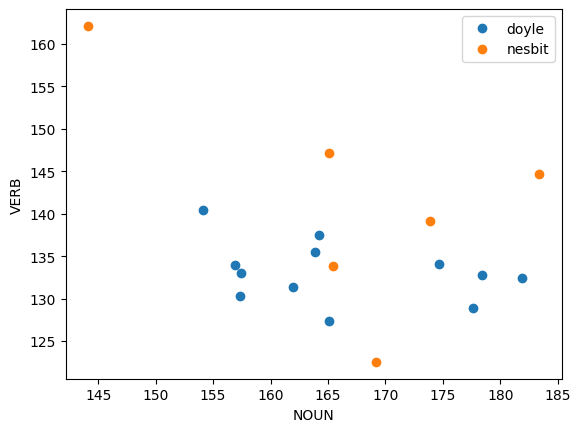

In [28]:
# define the features I want to look at
feat_x = 'NOUN'
feat_y = 'VERB'

# extract the list of author names from the table
#   - this is for labelling the points
authors = pos_freq.index.get_level_values(0)

# instantiate a new figure and axes
fig, ax = plt.subplots()

# add a new series to the plot for each author
for label, group in pos_freq.groupby(authors):
    ax.plot(group[feat_x], group[feat_y], marker='o', ls='', label=label)

# label the plot axes
ax.set_xlabel(feat_x)
ax.set_ylabel(feat_y)

# create a legend
ax.legend()

# display results
plt.show()

##### Try it out:

🤔 Try changing the part of speech values above and re-running the plot. Are some parts of speech better than others and differentiating the two authors?

### Lemma-based features

Let's try working with a larger feature set. This time, we'll use lemmas instead of part of speech tags. There are only 14 parts of speech in our table, but there are a lot of lemmas in this corpus.

Let's calculate the total number of occurrences for each lemma. This time, I'll use the `groupby()` method to split the table by lemmas. Then I'll **aggregate** the groups using the `agg()` method. This turns each group into a single value, based on whatever **aggregation function** I choose. If I wanted, I could aggregate different columns using different methods. 

For now, I'm just going to aggregate the `token` column and I'm going to use a simple count. The result will be a table with one row per unique lemma, and a column containing the count of the number of tokens that have that lemma.

In [33]:
# count tokens to produce a new table
token_count = tokens.groupby('lemma').agg(count=('token', 'count'))

# sort by count, decreasing order
token_count = token_count.sort_values('count', ascending=False)

display(token_count)

,count
lemma,
the,6791
be,5515
I,4983
and,3905
to,3319
...,...
linger,1
linoleum,1
arcadian,1


So there are 6345 unique lemmas in this corpus. How many are *hapax legomena*, occurring only once? I can use the fact that the `sum()` function counts `True` as 1 and `False` as 0:

In [35]:
sum(token_count['count'] == 1)

2643

Wow! So out of 6345 lemmas, more than a third are hapax legomena. This graph has a long tail! Does it follow Zipf's law?

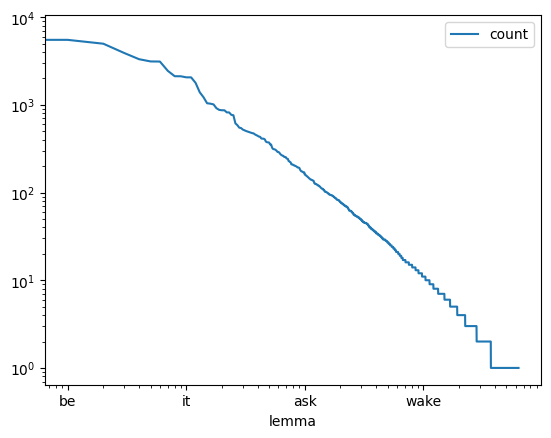

In [37]:
token_count.plot(loglog=True)
plt.show()

#### Feature selection

For authorship attribution, we want to work with just the function words. Generally this means working with the *n* **most frequent words** (MFW). The value of *n* is something that we might need to tune through trial and error. Let's start with the top 100.

In [40]:
token_count.iloc[:30]

,count
lemma,
the,6791
be,5515
I,4983
and,3905
to,3319
a,3129
of,3119
have,2441
in,2122


We'll take the row names from the top *n* lines and use that as our "keep" list.

In [41]:
mfw = token_count.iloc[:30].index.values
print(mfw)

['the' 'be' 'I' 'and' 'to' 'a' 'of' 'have' 'in' 'he' 'it' 'that' 'you'
 'my' 'his' 'she' 'as' 'with' 'at' 'not' 'for' 'we' 'which' 'but' 'do'
 'say' 'there' 'from' 'on' 'this']


I'll create a list of boolean values marking which rows in the token table match words in my feature set. I can use this as a mask to select just those rows in future operations.

In [42]:
selected = tokens.lemma.isin(mfw)

#### Calculate the feature vectors

Here we'll use `crosstab()` again, just as with the part of speech features. The only difference is I'm masking the token table so that I'm only working on rows that match my feature set.

In [43]:
lemma_count = pd.crosstab([tokens.loc[selected, 'author'],tokens.loc[selected, 'title']], tokens.loc[selected, 'lemma'])
display(lemma_count)

lemma                                           I    a  and  as  at   be  but  \
author title                                                                    
doyle  a_case_of_identity                     207  163  212  64  50  309   58   
       a_scandal_in_bohemia                   305  224  256  60  62  379   53   
       the_adventure_of_the_beryl_coronet     429  211  241  68  68  415   67   
       the_adventure_of_the_blue_carbuncle    231  208  200  49  54  353   55   
       the_adventure_of_the_copper_beeches    395  238  276  95  92  462   64   
       the_adventure_of_the_engineer’s_thumb  374  233  253  63  75  368   54   
       the_adventure_of_the_noble_bachelor    294  211  235  63  51  345   44   
       the_adventure_of_the_speckled_band     277  252  281  65  78  396   53   
       the_boscombe_valley_mystery            320  231  280  87  71  467   59   
       the_five_orange_pips                   211  149  232  60  52  292   34   
       the_man_with_the_twisted_lip           280  275  271  85  55  385   55   
       the_red-headed_league                  317  237  279  93  61  384   54   
nesbit from_the_dead                          403   94  181  41  38  191   35   
       man-size_in_marble                     242  106  232  40  31  228   26   
       the_ebony_frame                        403  164  222  63  47  278   55   
       the_mass_for_the_dead                  199   62  138  24   6  143   28   
       the_mystery_of_the_semi-detached         9   36   64   8   7   60   15   
       uncle_abraham’s_romance                 87   35   52   4  17   60   11   

lemma                                         do  for  from  ...  she  that  \
author title                                                 ...              
doyle  a_case_of_identity                     56   56    34  ...   51   134   
       a_scandal_in_bohemia                   50   46    45  ...   88   104   
       the_adventure_of_the_beryl_coronet     62   72    30  ...   74   185   
       the_adventure_of_the_blue_carbuncle    36   61    34  ...   15   122   
       the_adventure_of_the_copper_beeches    56   65    41  ...   73   165   
       the_adventure_of_the_engineer’s_thumb  29   55    48  ...   33   138   
       the_adventure_of_the_noble_bachelor    39   54    29  ...   91   151   
       the_adventure_of_the_speckled_band     53   67    54  ...   64   167   
       the_boscombe_valley_mystery            69   65    45  ...   30   171   
       the_five_orange_pips                   45   39    58  ...    3   122   
       the_man_with_the_twisted_lip           41   61    43  ...   58   134   
       the_red-headed_league                  61   85    36  ...    0   158   
nesbit from_the_dead                          56   41    26  ...  181    77   
       man-size_in_marble                     34   30    23  ...   81    69   
       the_ebony_frame                        37   40    24  ...   78    84   
       the_mass_for_the_dead                  33   18    11  ...   85    47   
       the_mystery_of_the_semi-detached        4   11     3  ...   17    20   
       uncle_abraham’s_romance                 9    2     3  ...   21    11   

lemma                                         the  there  this   to   we  \
author title                                                               
doyle  a_case_of_identity                     352     35    23  191   42   
       a_scandal_in_bohemia                   446     34    33  250   43   
       the_adventure_of_the_beryl_coronet     466     42    42  273   32   
       the_adventure_of_the_blue_carbuncle    463     36    60  193   57   
       the_adventure_of_the_copper_beeches    484     56    43  262   67   
       the_adventure_of_the_engineer’s_thumb  432     43    36  218   76   
       the_adventure_of_the_noble_bachelor    401     35    52  234   44   
       the_adventure_of_the_speckled_band     598     57    45  232  102   
       the_boscombe_valley_mystery    

In [ ]:
n_lemmas = tokens.groupby('title').agg(
    n=('lemma', 'count'),
    
)
lemma_freq = lemma_count.div(n_lemmas.n, axis=0) * 1000
display(lemma_freq)

In [ ]:
lemma_z = lemma_freq.sub(lemma_freq.mean(), axis=1).div(lemma_freq.std(), axis=1)
display(lemma_z)

In [ ]:
feat_x = 'and'
feat_y = 'but'

fig, ax = plt.subplots()
for label, group in lemma_z.groupby(authors):
    ax.plot(group[feat_x], group[feat_y], marker='o', ls='', label=label)
ax.set_xlabel(feat_x)
ax.set_ylabel(feat_y)
ax.legend()

In [ ]:
pca_model = PCA(n_components=3)

In [ ]:
pca = pd.DataFrame(
    pca_model.fit_transform(lemma_z),
    index = lemma_z.index,
    columns = ['PC1', 'PC2', 'PC3'],
)
display(pca)

In [ ]:
feat_x = 'PC1'
feat_y = 'PC2'

fig, ax = plt.subplots()
for label, group in pca.groupby(authors):
    ax.plot(group[feat_x], group[feat_y], marker='o', ls='', label=label)
ax.set_xlabel(feat_x)
ax.set_ylabel(feat_y)
ax.legend()